In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import v2


%matplotlib inline

In [2]:
def no_transform_collate(items):
    X = torch.stack([torchvision.transforms.functional.pil_to_tensor(item[0]) for item in items], dim=0).to(torch.float32)
    Y = torch.tensor([item[1] for item in items])
    return X, Y

In [3]:
CIFAR10_train = torchvision.datasets.CIFAR10("/media/lenny/e8491f8e-2ac1-4d31-a37f-c115e009ec90/Datasets", download=True)
CIFAR10_test = torchvision.datasets.CIFAR10("/media/lenny/e8491f8e-2ac1-4d31-a37f-c115e009ec90/Datasets", train=False, download=True)
train_loader_no = torch.utils.data.DataLoader(CIFAR10_train, batch_size=64, shuffle=True, num_workers=3, collate_fn=no_transform_collate)
test_loader_no = torch.utils.data.DataLoader(CIFAR10_test, batch_size=64, shuffle=True, num_workers=3, collate_fn=no_transform_collate)

Files already downloaded and verified
Files already downloaded and verified


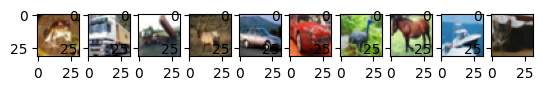

In [7]:
fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(CIFAR10_train[i][0])
plt.show()

## Convolutional Block
For our convoloutional base we are connecting 3 same padded convolutoins before a pooling layer. The reason for this is that 
we would like to convolve as much as possible before downsampling as the size of our images are extremely small. So if we 
frequently down sample the spatial dimension it will result in a network that is forced to be shallow. 

In [41]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding='same')
        self.kernel_size = kernel_size
    def forward(self, X):
        o = F.relu(self.conv1(X))
        o = F.relu(self.conv2(o))
        o = F.relu(self.conv3(o))
        return F.max_pool2d(o, kernel_size=self.kernel_size, stride=self.kernel_size)
        
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(*[ConvBlock(3, 64, 3, 1), ConvBlock(64, 128, 2, 1), ConvBlock(128, 256, 2, 1)])
        self.ff   = nn.Sequential(*[nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024, 256), nn.ReLU(), nn.Linear(256, 64),
                                    nn.ReLU(), nn.Linear(64, 10), nn.LogSoftmax(dim=-1)])
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        return self.ff(x)

In [4]:
def get_accuracy(model, loader, device):
    correct = 0
    total = 0
    for batch in loader:
        X = batch[0].to(device)
        Y = batch[1].to(device)
        pred = model(X)
        pred = torch.argmax(pred, dim=1)
        correct += (pred == Y).sum().item()
        total += X.shape[0]
    return correct / total


def train(model, epochs, loss, optim, train_loader, test_loader, device):
    for e in range(epochs):
        batch_loss = 0
        its = 0
        for batch in train_loader:
            its+=1
            optim.zero_grad()
            X = batch[0].to(device)
            Y = batch[1].to(device)
            pred = model(X)
            l = loss(pred, Y)
            batch_loss += l.item()
            l.backward()
            optim.step()
        print("Average Epoch Loss:", batch_loss/its)
        print("Train Accuracy:", get_accuracy(model, train_loader, device))
        print("Test Accuracy:", get_accuracy(model, test_loader, device))

In [5]:
device = torch.device('cuda')

In [57]:
model = CNN().to(device)
loss = nn.NLLLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=9e-5, weight_decay=0.001)

In [59]:
train(model, 40, loss, optim, train_loader, test_loader, device)

Average Epoch Loss: 0.4275795310888144
Train Accuracy: 0.8586
Test Accuracy: 0.7616
Average Epoch Loss: 0.41062163052808903
Train Accuracy: 0.87314
Test Accuracy: 0.7709
Average Epoch Loss: 0.37438919029348644
Train Accuracy: 0.88202
Test Accuracy: 0.7736
Average Epoch Loss: 0.3592969311682312
Train Accuracy: 0.88286
Test Accuracy: 0.7707
Average Epoch Loss: 0.32942390081751377
Train Accuracy: 0.85176
Test Accuracy: 0.7448
Average Epoch Loss: 0.3079032071620759
Train Accuracy: 0.9167
Test Accuracy: 0.7861
Average Epoch Loss: 0.28114485305250453
Train Accuracy: 0.92502
Test Accuracy: 0.7861
Average Epoch Loss: 0.2623743071599537
Train Accuracy: 0.92122
Test Accuracy: 0.7774
Average Epoch Loss: 0.24057063546098406
Train Accuracy: 0.90786
Test Accuracy: 0.7616
Average Epoch Loss: 0.22525475664383462
Train Accuracy: 0.92668
Test Accuracy: 0.7761
Average Epoch Loss: 0.20322144175867748
Train Accuracy: 0.93806
Test Accuracy: 0.7747
Average Epoch Loss: 0.18967255746083492
Train Accuracy: 0.94

## Final Results
The model preforms pretty well correctly classifying examples with a 78% accuracy. It is clear however that we face a problem of 
overfitting as our train accuracy is well over 20% more. We tried to combat this by adding weight decay to the Adam Optimizer but this didn't
help. Prephaps a different architecture could fair better. If a different architecture had an easier time solving this problem the disparity
between the train/test accuracy wouldn't be as large. We also could try to add more regularization to the model for example dropout. The 
last thing which I believe will help with overfitting is data augmentation, this will allow us to have a psuedo larger dataset and
as a result of having "more" data the overfitting should be less.

## ResNet 50
We move on to fine tuning a resnet 50 to solve the task at hand. The resnet acheives a higher train accuracy and test accuracy
then the model we trained. The model still greatly suffers from overfitting. The reason why it preforms better can possibly be attributed
to the larger size of the resnet compared to our model. But the most interesting part is how quickly the model learns. The model had
tied our train preformance after just 4 epochs. This can be attributed to the resnets pre training, which learned valuable intermediate
features for an image classificatin task. This allowed the model to only really have to change the later layers where these features
are translated into more class specific features used for classification. 

In [15]:
r = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

In [16]:
r.fc = nn.Sequential(*[nn.Linear(2048, 10), nn.LogSoftmax(dim=-1)]).to(device)

In [17]:
optim = torch.optim.Adam(params=r.parameters(), lr=3e-5, weight_decay=0.0001)
loss  = nn.NLLLoss()
train(r, 20, loss, optim, train_loader_no, test_loader_no, device)

Average Epoch Loss: 1.8507745400109255
Train Accuracy: 0.60768
Test Accuracy: 0.5806
Average Epoch Loss: 0.9680013648994134
Train Accuracy: 0.76112
Test Accuracy: 0.7178
Average Epoch Loss: 0.6624451852439309
Train Accuracy: 0.82622
Test Accuracy: 0.7608
Average Epoch Loss: 0.5052811233969905
Train Accuracy: 0.87248
Test Accuracy: 0.7857
Average Epoch Loss: 0.3892458681293461
Train Accuracy: 0.90126
Test Accuracy: 0.7959
Average Epoch Loss: 0.302828254211513
Train Accuracy: 0.92646
Test Accuracy: 0.8014
Average Epoch Loss: 0.23783209571219466
Train Accuracy: 0.94462
Test Accuracy: 0.8095
Average Epoch Loss: 0.17866025681195358
Train Accuracy: 0.95586
Test Accuracy: 0.8166
Average Epoch Loss: 0.14101226765738653
Train Accuracy: 0.9653
Test Accuracy: 0.8194
Average Epoch Loss: 0.1190280818816303
Train Accuracy: 0.97322
Test Accuracy: 0.8179
Average Epoch Loss: 0.10129718788330207
Train Accuracy: 0.97722
Test Accuracy: 0.8225
Average Epoch Loss: 0.08040269540832437
Train Accuracy: 0.9807


KeyboardInterrupt: 

In [110]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(180), 
])
def collate(items):
    X = torch.stack([torchvision.transforms.functional.pil_to_tensor(item[0]) for item in items], dim=0).to(torch.float32)
    Y = torch.tensor([item[1] for item in items])
    X = transforms(X)
    return X, Y

In [111]:
train_loader = torch.utils.data.DataLoader(CIFAR10_train, batch_size=64, shuffle=True, num_workers=3, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=64, shuffle=True, num_workers=3, collate_fn=collate)

In [133]:
device = torch.device('cuda')
model = CNN().to(device)
loss = nn.NLLLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=3e-6, weight_decay=0.0001)

In [134]:
train(model, 20, loss, optim, train_loader, test_loader, device)

Average Epoch Loss: 0.5431189116690774
Train Accuracy: 0.80892
Test Accuracy: 0.7562
Average Epoch Loss: 0.5392630705633736
Train Accuracy: 0.8088
Test Accuracy: 0.753
Average Epoch Loss: 0.5415044558208312
Train Accuracy: 0.81204
Test Accuracy: 0.7564
Average Epoch Loss: 0.5423032314804814
Train Accuracy: 0.8111
Test Accuracy: 0.7579
Average Epoch Loss: 0.5391224206561018
Train Accuracy: 0.80846
Test Accuracy: 0.7537
Average Epoch Loss: 0.5399757607475572
Train Accuracy: 0.81248
Test Accuracy: 0.7505
Average Epoch Loss: 0.5358066124570035
Train Accuracy: 0.80998
Test Accuracy: 0.753
Average Epoch Loss: 0.5358358817865781
Train Accuracy: 0.80836
Test Accuracy: 0.7527
Average Epoch Loss: 0.5344197068677838
Train Accuracy: 0.81144
Test Accuracy: 0.7504
Average Epoch Loss: 0.53721221345846
Train Accuracy: 0.81052
Test Accuracy: 0.7566
Average Epoch Loss: 0.5360151885453698
Train Accuracy: 0.8114
Test Accuracy: 0.758
Average Epoch Loss: 0.5356473581260427
Train Accuracy: 0.81202
Test Accur

KeyboardInterrupt: 

In [132]:
#Get accuracy on non-transformed test set
get_accuracy(model, test_loader_no, device)

0.7613

## Data Augmentation
Using data augmentation should have resulted in less overfitting and possibly better overall preformance. The reason is 
the model is being trained with "more" data. However this is not what occured. This is most likely a result of not well chosen hyper parameters. Despite trying multiple learning rates and weight decay values, I could not acheive better preformance then the model trained
on the vanilla dataset. The intermediate accuracies during training are also lower than the intermediates during the vanilla training. However this can be explained by the fact that the augmented dataset is "harder" to learn as a result of these augmentations. This new dataset will force the model to be translation invariant which is something that the orignal dataset necessarily required or at least
not to the degree of the augmented d

## Image Generation 
For Part 2 of the assignment I use this implementation (https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb) of the VAE in pytorch in order to generate fashion MNSIT images which have been converted to
black and white. 


In [3]:
def gray_scale_collate(items):
    X = torch.stack([torchvision.transforms.functional.pil_to_tensor(item[0].convert('L')) for item in items], dim=0).to(torch.float32)
    X = X.squeeze(1)
    X = (X > 30).to(torch.float32)
    Y = torch.tensor([item[1] for item in items])
    return X, Y

In [4]:
fashion_train = torchvision.datasets.FashionMNIST("/media/lenny/e8491f8e-2ac1-4d31-a37f-c115e009ec90/Datasets", download=True)
fashion_test = torchvision.datasets.FashionMNIST("/media/lenny/e8491f8e-2ac1-4d31-a37f-c115e009ec90/Datasets", train=False, download=True)
train_loader_no = torch.utils.data.DataLoader(fashion_train, batch_size=64, shuffle=True, num_workers=3, collate_fn=gray_scale_collate)
test_loader_no = torch.utils.data.DataLoader(fashion_test, batch_size=64, shuffle=True, num_workers=3, collate_fn=gray_scale_collate)

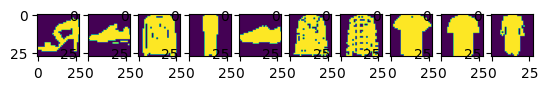

In [5]:
fig, ax = plt.subplots(1,10)
b,_ = next(iter(train_loader_no))
for i in range(10):
    ax[i].imshow(b[i])
plt.show()


In [6]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                    
                                                       
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        
        z = mean + var*epsilon                          
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var




In [7]:

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


In [11]:
encoder = Encoder(input_dim=784, hidden_dim=400, latent_dim=200)
decoder = Decoder(latent_dim=200, hidden_dim = 400, output_dim = 784)
model = Model(Encoder=encoder, Decoder=decoder).to(device)
epochs = 40
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-3)



In [12]:


print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader_no):
        x = x.reshape(x.shape[0], -1)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*x.shape[0]))
    
print("Finish!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  346.84240988911534
	Epoch 2 complete! 	Average Loss:  257.1026025403653
	Epoch 3 complete! 	Average Loss:  240.84513832181852
	Epoch 4 complete! 	Average Loss:  232.4098917860359
	Epoch 5 complete! 	Average Loss:  227.2384198818797
	Epoch 6 complete! 	Average Loss:  223.7472470180711
	Epoch 7 complete! 	Average Loss:  220.14991967884174
	Epoch 8 complete! 	Average Loss:  218.39487216261432
	Epoch 9 complete! 	Average Loss:  216.80910352708943
	Epoch 10 complete! 	Average Loss:  215.50082549723135
	Epoch 11 complete! 	Average Loss:  213.97107023159748
	Epoch 12 complete! 	Average Loss:  213.27784504274675
	Epoch 13 complete! 	Average Loss:  212.19371454489269
	Epoch 14 complete! 	Average Loss:  211.52444205594546
	Epoch 15 complete! 	Average Loss:  210.53056021968226
	Epoch 16 complete! 	Average Loss:  209.99774906805766
	Epoch 17 complete! 	Average Loss:  209.4175955040605
	Epoch 18 complete! 	Average Loss:  208.97775576336025
	E

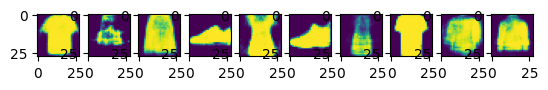

In [18]:
with torch.no_grad():
    noise = torch.randn(10, 200).to(device)
    generated_images = decoder(noise)
    
fig, ax = plt.subplots(1,10)
b = generated_images 
for i in range(10):
    ax[i].imshow(b[i].cpu().reshape(28,28))
plt.show()


## GYAAANNNNNT

In [110]:
D = nn.Sequential(*[nn.Linear(784, 1024), nn.LeakyReLU(0.2), nn.Linear(1024, 1024), nn.LeakyReLU(0.2), 
                    nn.Linear(1024, 512), nn.LeakyReLU(0.2), nn.Linear(512, 1), nn.Sigmoid()]).to(device)
G = nn.Sequential(*[nn.Linear(200, 1024), nn.LeakyReLU(0.2), nn.Linear(1024, 1024), nn.LeakyReLU(0.2), 
                    nn.Linear(1024, 1024), nn.LeakyReLU(0.2), nn.Linear(1024, 784), nn.Sigmoid()]).to(device)

In [114]:
G_optim = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optim = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
crit = nn.BCELoss()

In [115]:
def gan_train(G, D, batch_size, epochs, loss, d_optim, g_optim, train_loader, device):
   
    for e in range(epochs):
        batch_loss = 0
        its = 0
        for batch in train_loader:
            
            its+=1
            d_optim.zero_grad()
            g_optim.zero_grad()
            X = batch[0].to(device)
            X = X.reshape(X.shape[0], 784)
            ones = torch.ones(X.shape[0],1).to(device)
            zeros = torch.zeros(X.shape[0],1).to(device)
            pred = D(X)
            l_true = loss(pred, ones)

            noise = torch.randn(X.shape[0], 200).to(device)
            gen_images = G(noise)
            
            l_false = loss(D(gen_images.detach()), zeros)
            l = l_true + l_false
            l.backward()
            d_optim.step()
            
            noise = torch.randn(X.shape[0], 200).to(device)
            gen_images = G(noise)
            l_2 = loss(D(gen_images), ones)
            batch_loss += l_2.item()
            l_2.backward()
            g_optim.step()
        print(e, "Average Epoch Loss:", batch_loss/its)


In [116]:
gan_train(G, D, 64, 30, crit, D_optim, G_optim, train_loader_no, device)

0 Average Epoch Loss: 3.428829316502568
1 Average Epoch Loss: 2.923074412447557
2 Average Epoch Loss: 2.675178109709896
3 Average Epoch Loss: 2.246380019226054
4 Average Epoch Loss: 2.1780081883803613
5 Average Epoch Loss: 2.0957452881056615
6 Average Epoch Loss: 2.0935773318891586
7 Average Epoch Loss: 1.9203490265396868
8 Average Epoch Loss: 1.7851941886741216
9 Average Epoch Loss: 1.7537915347608677
10 Average Epoch Loss: 1.805519496009294
11 Average Epoch Loss: 1.807670866566172
12 Average Epoch Loss: 1.7156883725987824
13 Average Epoch Loss: 1.5900837470854778
14 Average Epoch Loss: 1.5742223216399456
15 Average Epoch Loss: 1.5673287048268674
16 Average Epoch Loss: 1.5310399991108665
17 Average Epoch Loss: 1.514282910745027
18 Average Epoch Loss: 1.51458241811185
19 Average Epoch Loss: 1.5217194925747446
20 Average Epoch Loss: 1.5169291817176063
21 Average Epoch Loss: 1.5169316779957143
22 Average Epoch Loss: 1.5229223898606006
23 Average Epoch Loss: 1.5349079945575455
24 Average 

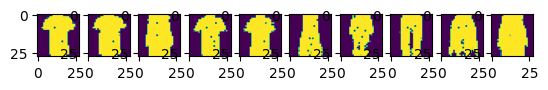

In [117]:
with torch.no_grad():
    noise = torch.randn(10, 200).to(device)
    generated_images = G(noise)
    
fig, ax = plt.subplots(1,10)
b = generated_images 
for i in range(10):
    ax[i].imshow(b[i].cpu().reshape(28,28))
plt.show()

In [134]:
torch.save(D.state_dict(), "Discrim.pth")
torch.save(G.state_dict(), "Gen.pth")